In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

import ray
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

# Prep data

In [4]:
prog_start = time.time()

In [5]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [6]:
route_types = ['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']
runners = tracking_df.loc[(tracking_df['position'].isin(['QB', 'WR', 'RB', 'TE']))].copy()
del tracking_df

In [7]:
runners['pos'] = runners['pos'].apply(string_to_vector)
runners['o_vec'] = runners['o_vec'].apply(string_to_vector)
runners['dir_vec'] = runners['dir_vec'].apply(string_to_vector)
runners['r_vec'] = runners['r_vec'].apply(string_to_vector)
runners['gpid'] = runners.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [8]:
qb_positions = runners.loc[(runners['frameId'] == 1) & (runners['position'] == 'QB')][['gpid', 'pos']].copy()

In [9]:
indexNames = runners[runners['route'] == 'undefined'].index
indexNames
# Delete these row indexes from dataFrame
runners.drop(indexNames , inplace=True)

In [10]:
runners = runners.loc[(~runners['route'].isna())]

In [11]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [12]:
gpids = runners['gpid'].unique().tolist()

In [13]:
@ray.remote
def process_data(dataset, qb_positions):
    routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
    index = 0
    end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

    gpids = dataset['gpid'].unique().tolist()
    for gpid in gpids:
        try:
            df = dataset.loc[dataset['gpid'] == gpid]
            players = df['nflId'].unique().tolist()
            centre_pos = qb_positions.loc[(qb_positions['gpid'] == gpid)]['pos'].values[0][1]
            for player in players:
                player_df = df.loc[(df['nflId'] == player)]
                if player > 0:
                    start_frame = player_df.loc[player_df['event'] == 'ball_snap']['frameId'].min()
                    end_frame = player_df.loc[player_df['event'].isin(end_events)]['frameId'].min()
                    if end_frame > start_frame:
                        positions = []
                        start_pos = player_df.loc[(player_df['frameId'] == start_frame)]['pos'].values[0]
                        flip_arr = True if start_pos[1] < centre_pos else False
                        for frame in range(start_frame + 1, end_frame + 1):
                            # positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                            new_pos = player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist()
                            if flip_arr: new_pos[1] = new_pos[1] * -1
                            new_pos.append(player_df.loc[(player_df['frameId'] == frame)]['s'].values[0])
                            positions.append(new_pos)
                        positions = np.array(positions)
                        routes_df.loc[index] = {
                            'gpid': str(gpid),
                            'nflId': int(player),
                            'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                            'pos': positions - positions[0]
                        }
                        index += 1
        except IndexError:
            print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')
    return routes_df

In [14]:
n_procs = 24
ray.shutdown()
ray.init(num_cpus=n_procs)

RayContext(dashboard_url='', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-02_17-10-36_458586_38561/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-02_17-10-36_458586_38561/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-02_17-10-36_458586_38561', 'metrics_export_port': 58557, 'gcs_address': '127.0.0.1:56272', 'address': '127.0.0.1:56272', 'node_id': '67e5b332b94337666db51809be98f5894c83170ee30bd408d7752158'})

In [15]:
n_gpids = len(gpids)
max_gpids = int(len(gpids[:n_gpids]))
gpid_sets = []
set_pos = 0
step = int(max_gpids / (n_procs - 1))

while set_pos < max_gpids:
    start = 0 if set_pos == 0 else set_pos + 1
    set_pos = set_pos + step
    end = set_pos if set_pos < max_gpids else max_gpids
    gpid_sets.append((start, end))

In [16]:
# Generate vectors of positions
start = time.time()

routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
futures = [process_data.remote(runners.loc[(runners['gpid'].isin(gpids[idx[0]:idx[1]]))], qb_positions) for idx in gpid_sets]
results = ray.get(futures)

for i in range(0, len(results)):
    routes_df = pd.concat([routes_df, results[i]], ignore_index=True)

finish = time.time()
print(f'Took {finish - start} seconds')
routes_df.head()

(process_data pid=38640) Data error for gpid 2018100702-4007, player 2556190 (Start 11 | End 44)
(process_data pid=38638) Data error for gpid 2018112508-1729, player 2561272 (Start 11 | End 44)
(process_data pid=38639) Data error for gpid 2018121000-1364, player 2557991 (Start 11 | End 42)
Took 240.58819103240967 seconds


,gpid,nflId,route,pos
0,2018090600-75,2495454,HITCH,"[[0.0, 0.0, 0.0], [0.030000000000001137, 0.0, ..."
1,2018090600-75,2533040,HITCH,"[[0.0, 0.0, 0.0], [0.010000000000001563, 0.0, ..."
2,2018090600-75,2555415,OUT,"[[0.0, 0.0, 0.0], [0.010000000000001563, 0.009..."
3,2018090600-146,2543583,FLAT,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.04], [0.0099999..."
4,2018090600-146,2552418,CROSS,"[[0.0, 0.0, 0.0], [0.01999999999999602, 0.0199..."


In [17]:
# Convert position sequences to 2d array with np.histogram2d

In [18]:
# Convert 2d array to 1d array

In [19]:
@ray.remote
def find_min_max_from_dataframe(df):
    x = [0, 0]
    y = [0, 0]

    for idx, row in df.iterrows():
        if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
        if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
        if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
        if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()

    x = [np.floor(x[0]), np.ceil(x[1])]
    y[0] = -1 * np.ceil(max(abs(y[0]), abs(y[1])))
    y[1] = abs(y[0])

    return x, y

In [20]:
def find_min_max_from_arrays(x_list, y_list):
    x = [0, 0]
    x[0] = x_list[:, 0].min()
    x[1] = x_list[:, 1].max()

    y = [0, 0]
    y[1] = np.abs(y_list.max())
    y[0] = -y[1]

    return x, y

In [21]:
n_rows = len(routes_df)
max_rows = int(len(routes_df[:n_rows]))
row_sets = []
set_pos = 0
step = int(max_rows / (n_procs - 1))

while set_pos < max_rows:
    start = 0 if set_pos == 0 else set_pos + 1
    set_pos = set_pos + step
    end = set_pos if set_pos < max_rows else max_rows
    row_sets.append((start, end))

print(row_sets)

[(0, 2841), (2842, 5682), (5683, 8523), (8524, 11364), (11365, 14205), (14206, 17046), (17047, 19887), (19888, 22728), (22729, 25569), (25570, 28410), (28411, 31251), (31252, 34092), (34093, 36933), (36934, 39774), (39775, 42615), (42616, 45456), (45457, 48297), (48298, 51138), (51139, 53979), (53980, 56820), (56821, 59661), (59662, 62502), (62503, 65343), (65344, 65364)]


In [22]:
start = time.time()

x = []
y = []

futures = [find_min_max_from_dataframe.remote(routes_df[idx[0]:idx[1]]) for idx in row_sets]
results = ray.get(futures)

for i in range(0, len(results)):
    x.append(results[i][0])
    y.append(results[i][1])

x, y = find_min_max_from_arrays(np.array(x), np.array(y))

finish = time.time()
print(f'Took {finish - start} seconds')
print(x, y)

Took 0.46046900749206543 seconds
[-34.0, 68.0] [-45.0, 45.0]


In [23]:
x_dim = int(abs(x[0]) + abs(x[1]))
y_dim = int(abs(y[0]) + abs(y[1]))

In [24]:
grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)

In [25]:
grids = []
for idx, row in routes_df.iterrows():
    grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)
    for position in row['pos']:
        grid[int(position[0]), int(position[1])] = position[2]
    grids.append(grid.reshape(x_dim * y_dim))

In [26]:
routes_df['grid'] = grids
#routes_df.drop(['pos'], axis=1, inplace=True)

In [27]:
prog_end = time.time()
print(f'Program took {prog_end - prog_start} seconds')

Program took 382.0099241733551 seconds


## SVM

In [ ]:
# flatten the images
n_samples = len(grids)

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.005, kernel='rbf', max_iter=1000)

# Split data into 60% train and 40% test subsets
x_train, x_test, y_train, y_test = train_test_split(routes_df['grid'].tolist(), routes_df['route'], test_size=0.4, shuffle=False, random_state=1)
scaler = StandardScaler()

scaler.fit(x_train)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)


# Learn the digits on the train subset
clf.fit(x_train2, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(x_test2)

*** SIGTERM received at time=1654161394 ***
PC: @        0x168be5fe0  (unknown)  .Ldot_kernel_F4
[2022-06-02 17:16:34,315 E 38561 2517909] logging.cc:325: *** SIGTERM received at time=1654161394 ***
[2022-06-02 17:16:34,316 E 38561 2517909] logging.cc:325: PC: @        0x168be5fe0  (unknown)  .Ldot_kernel_F4


In [ ]:
print(
    f'Classification report for classifier {clf}:\n'
    f'{metrics.classification_report(y_test, predicted)}\n'
)

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [ ]:
routes_df['route'].value_counts().sum()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(routes_df['route'].value_counts().index, routes_df['route'].value_counts().values / routes_df['route'].value_counts().sum(), width=0.75)

In [ ]:
routes_df['route'].count()

In [ ]:
routes_df.loc[routes_df['route'] == 'WHEEL']['route'].count()

## MLP Classifier

In [ ]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

In [ ]:
clf2 = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
clf2.fit(x_train2, y_train)

In [ ]:
predicted2 = clf2.predict(x_test2)

In [ ]:
print(
    f'Classification report for classifier {clf2}:\n'
    f'{metrics.classification_report(y_test, predicted2)}\n'
)

In [ ]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted2)
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.show()

## Random Forest

In [ ]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)

In [ ]:
model.fit(x_train2, y_train)

In [ ]:
y_pred = model.predict(x_test2)

In [ ]:
accuracy_score(y_pred, y_test)
print(classification_report(y_pred, y_test))

In [ ]:
confusion_matrix(y_pred, y_test)

## Pytorch

In [28]:
classes = {}
index = 0
for route in routes_df['route'].unique().tolist():
    classes[index] = route
    index += 1
classes

{0: 'HITCH',
 1: 'OUT',
 2: 'FLAT',
 3: 'CROSS',
 4: 'GO',
 5: 'SLANT',
 6: 'SCREEN',
 7: 'CORNER',
 8: 'IN',
 9: 'ANGLE',
 10: 'POST',
 11: 'WHEEL'}

In [29]:
route_idx = {}
for idx, value in classes.items():
    route_idx[value] = idx
route_idx

{'HITCH': 0,
 'OUT': 1,
 'FLAT': 2,
 'CROSS': 3,
 'GO': 4,
 'SLANT': 5,
 'SCREEN': 6,
 'CORNER': 7,
 'IN': 8,
 'ANGLE': 9,
 'POST': 10,
 'WHEEL': 11}

In [30]:
routes_df['route_int'] = routes_df['route'].apply(lambda x: route_idx[x])

In [31]:
routes_df.loc[(routes_df['route_int'] == 12)]

,gpid,nflId,route,pos,grid,route_int


In [32]:
# Create device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [33]:
class MultiClassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=0):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

In [34]:
LEARNING_RATE = 0.5
EPOCHS = 2000
HIDDEN_UNITS = 256

In [35]:
torch.manual_seed(42)
mc_model = MultiClassModel(input_features=x_dim*y_dim, output_features=len(classes), hidden_units=HIDDEN_UNITS).to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(mc_model.parameters(), lr=LEARNING_RATE)
epochs = EPOCHS

# Split data into 80% train and 20% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route_int'], test_size=0.2, shuffle=False, random_state=1)
x_train, y_train = torch.as_tensor(x_train).float().to(device), torch.as_tensor(y_train.to_numpy()).to(device)
x_test, y_test = torch.as_tensor(x_test).float().to(device), torch.as_tensor(y_test.to_numpy()).to(device)

for epoch in range(epochs):
    ### Training
    mc_model.train()

    # 1. Forward Pass
    y_logits = mc_model(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and energy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimiser zero grad (clear gradients)
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    ### Testing
    mc_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = mc_model(x_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        pass
        #print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

/tmp/ipykernel_136722/2358118172.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x_train, y_train = torch.as_tensor(x_train).float().to(device), torch.as_tensor(y_train.to_numpy()).to(device)


In [36]:
mc_model.eval()
with torch.inference_mode():
    y_logits = mc_model(x_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

#print(f'Predictions: {y_preds}\nLabels: {y_test}')
print(f'Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds):.2f}%')

Test accuracy: 63.47%


In [37]:
len(routes_df)

65364

In [38]:
print(
    f'Classification report for classifier {mc_model}:\n'
    f'{metrics.classification_report(y_test.cpu(), y_preds.cpu())}\n'
)

Classification report for classifier MultiClassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=9180, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=12, bias=True)
  )
):
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      2124
           1       0.55      0.78      0.64      1378
           2       0.74      0.81      0.77      1837
           3       0.66      0.71      0.68      1230
           4       0.66      0.67      0.66      2493
           5       0.56      0.56      0.56       745
           6       0.53      0.43      0.48       478
           7       0.62      0.30      0.41       493
           8       0.73      0.47      0.57       961
           9       0.66      0.25      0.36       452
          10       0.52      0.58      0.55       828
          11       0.44      0.28   

Confusion Matrix:
[[1371  202   22   69  209   87   19    9   52   15   68    1]
 [  71 1070   47   28   85   17   12   18    8    8   13    1]
 [  11  134 1482   85   29    9   66    0    3    9    1    8]
 [  16   34   81  877   72   73   28    1    7    0   41    0]
 [ 297  168   81   20 1666   17   22   61   12    6  135    8]
 [  87   34   17   98   45  415   11    1   23    5    9    0]
 [  14   21  188   24   12    5  206    0    1    6    1    0]
 [  29  142    4   18  130    2    2  149    1    0   16    0]
 [ 107   46    5   52   71   75    2    1  449    6  147    0]
 [ 109   87   51    8   31   23   14    0    9  114    5    1]
 [  40   12    1   54  168   14    4    1   48    2  484    0]
 [   0    3   12    1   16    0    2    1    0    2    2   15]]


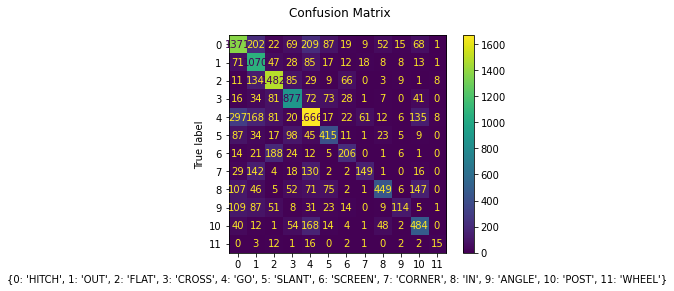

In [39]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test.cpu(), y_preds.cpu())
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.xlabel(classes)
plt.show()